# Boost half bridge example

In [1]:
import numpy as np

def calc_boost_converter_L_waveforms(Vi, Vo, P, w, fs):
    L_waveforms = []
    for k in range(len(Vi)):
        t = np.linspace(0, 1/fs[k], num=int(fs[k]), endpoint=False)
        vl = np.zeros_like(t)
        vl[t * fs[k] < Vi[k] / Vo[k]] = Vo[k]
        vl = vl - np.mean(vl)
        ildc = np.ones_like(t) * P[k] / Vi[k]
        this_L_waveforms = {
            't': t,
            'vl': vl,
            'ildc': ildc,
            'P': P[k],
            'w': w[k]
        }
        L_waveforms.append(this_L_waveforms)
    return L_waveforms

Vls: 200, Vhs: 850, Pls: 20000, w: 0.2, fs: 40000.0
Vls: 425, Vhs: 850, Pls: 42500, w: 0.4, fs: 40000.0
Vls: 200, Vhs: 400, Pls: 20000, w: 0.4, fs: 40000.0


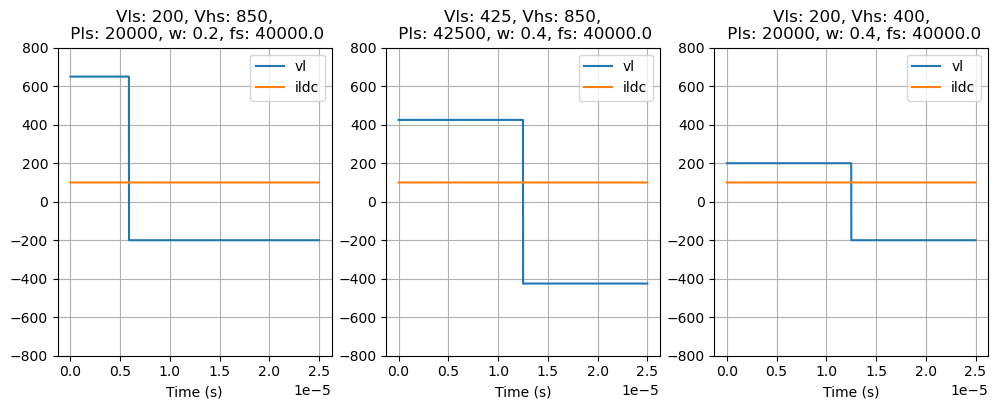

In [10]:
# Example usage
Vls = [200, 425, 200] 
Vhs = [850, 850, 400]
Ils = [100, 100, 100]
Pls = [Vls[k] * Ils[k] for k in range(len(Vls))]
w = [0.2, 0.4, 0.4]
fs = 40e3*np.ones_like(Vls)

d_op = {}
for k in range(len(Vls)):
    print(f"Vls: {Vls[k]}, Vhs: {Vhs[k]}, Pls: {Pls[k]}, w: {w[k]}, fs: {fs[k]}")
    d_op[k] = {'vls': Vls[k], 'vhs': Vhs[k], 'pls': Pls[k], 'w': w[k], 'fs': fs[k]}

L_waveforms = calc_boost_converter_L_waveforms(Vls, Vhs, Pls, w, fs)

# plot the waveforms
import matplotlib.pyplot as plt

# plot the waveforms in subplots for each waveform 
# grid of plots is based on the number of waveforms chosen as sqrt of the number of waveforms

n_waveforms = len(L_waveforms)
n_rows = int(np.sqrt(n_waveforms))
n_cols = int(np.ceil(n_waveforms / n_rows))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))

for k, L_waveform in enumerate(L_waveforms):
    ax = axs.flatten()[k]
    ax.plot(L_waveform['t'], L_waveform['vl'], label='vl')
    ax.plot(L_waveform['t'], L_waveform['ildc'], label='ildc')
    ax.set_title(f"Vls: {Vls[k]}, Vhs: {Vhs[k]},\n Pls: {Pls[k]}, w: {w[k]}, fs: {fs[k]}")
    ax.set_xlabel('Time (s)')
    # ax.set_ylabel('Voltage (V) / Current (A)')
    ax.grid()
    # align the y-axis labels
    ax.set_yticks(np.linspace(-800, 800, num=9))
    ax.legend()

In [ ]:
# Placeholder function for find_opt_boost_inductor_material
def find_opt_boost_inductor_material(geometry, requirements, L_waveforms, csc_materials):
    # Implement the actual logic here
    return csc_materials[0]  # Example: return the first material

# Placeholder function for calc_boost_inductor_temperature
def calc_boost_inductor_temperature(geometry, results):
    # Implement the actual logic here
    return results

In [ ]:
import numpy as np

def find_opt_boost_inductor_material(geometry, requirements, L_waveforms, material_names):
    eta_weighted = np.zeros(len(material_names))
    temp = np.zeros(len(material_names))

    for km in range(len(material_names)):
        geometry['mag_mat_name'] = material_names[km]
        this_results = calc_boost_inductor_loss(geometry, requirements, L_waveforms)
        this_results = calc_boost_inductor_temperature(geometry, this_results)

        eta_weighted[km] = this_results['eta_weighted']
        temp[km] = this_results['Tmax']

    # Find the material with the minimum temperature
    ix = np.argmin(temp)
    opt_material = material_names[ix]

    return opt_material

In [ ]:
requirements = {
    'Lmin': 0.01e-6,  # minimal inductance
    'Ilfmax': 1.2 * Ilftot / phases,  # low frequency inductor current (to find mu_r)
    'Psihfmax': Vi / (4 * fs)  # high frequency flux linkage
}

# Define the geometry
geometry = {
    'conductor_type': 'round single layer',
    'sigma': 5.6e7 / (1 + (150 - 20) * 4e-3),
    'kcu': None,
    'dr': None,
    'mag_mat_name': None,
    'ww': None,
    'Nset': 42,
    'potting_lambda': 1,  # was 1.6
    'potting_thickness': 3e-3,
    'Ta': 70
}

# Define the materials
#csc_materials = {'CSC MPP 125u','CSC MPP 147u','CSC MPP 160u','CSC MPP 173u','CSC MPP 200u','CSC High Flux 26u','CSC High Flux 60u','CSC High Flux 125u','CSC High Flux 147u','CSC High Flux 160u','CSC Sendust 26u','CSC Sendust 60u','CSC Sendust 75u','CSC Sendust 90u','CSC Sendust 125u','CSC Mega Flux 26u','CSC Mega Flux 50u','CSC Mega Flux 60u','CSC Mega Flux 75u','CSC Mega Flux 90u'};
#csc_materials = {'CSC Sendust 26u','CSC Sendust 60u','CSC Sendust 75u','CSC Sendust 90u','CSC Sendust 125u'}
csc_materials = {'CSC Mega Flux 26u','CSC Mega Flux 60u','CSC Mega Flux 75u','CSC Mega Flux 90u'}
#csc_materials = {'CSC High Flux 26u','CSC High Flux 60u','CSC High Flux 125u','CSC High Flux 147u','CSC High Flux 160u'}

[opt_material] = find_opt_boost_inductor_material(geometry,requirements,L_waveforms,csc_materials)

geometry['mag_mat_name'] = opt_material

results = calc_boost_inductor_temperature(geometry, results)
results['Ptot'] = results['Pc'] + results['Pwdc'] + results['Pwac']
results['Bpk'] = (results['Lmin'] * requirements['Ilfmax'] + requirements['Psihfmax']) / (results['Nopt'] * geometry['Ac'])
results['Bac'] = requirements['Psihfmax'] / (results['Nopt'] * geometry['Ac'])
results['WireLength'] = results['Nopt'] * geometry['lw']
results['DeltaIl'] = requirements['Psihfmax'] / requirements['Lmin']
results['Pwmax'] = max(results['Pwdc']) + max(results['Pwac'])
results['Pcmax'] = max(results['Pc'])
results['Ecalc'] = results['Lmin'] * Ilftot / phases * (Ilftot / phases + results['DeltaIl'])

print("Ecalc:", results['Ecalc'])
print("Max Ptot:", max(results['Ptot']))